# Baseline and model pipelines
features QRN

In [0]:
blob_container = "blobcontainer" # The name of your container created in https://portal.azure.com
storage_account = "w261section05group03" # The name of your Storage account created in https://portal.azure.com
secret_scope = "w261section05group04" # The name of the scope created in your local computer using the Databricks CLI
secret_key = "houseofthedragon" # The name of the secret key created in your local computer using the Databricks CLI 
blob_url = f"wasbs://{blob_container}@{storage_account}.blob.core.windows.net"
mount_path = "/mnt/mids-w261"

spark.conf.set(
  f"fs.azure.sas.{blob_container}.{storage_account}.blob.core.windows.net",
  dbutils.secrets.get(scope = secret_scope, key = secret_key)
)

In [0]:
data_BASE_DIR = "dbfs:/mnt/mids-w261/datasets_final_project_2022/"
display(dbutils.fs.ls(f"{data_BASE_DIR}"))

path name size modificationTime dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data/ parquet_airlines_data/ 0 1656618287000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_1y/ parquet_airlines_data_1y/ 0 1656630272000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_3m/ parquet_airlines_data_3m/ 0 1656630114000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_airlines_data_6m/ parquet_airlines_data_6m/ 0 1656630205000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data/ parquet_weather_data/ 0 1656622074000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_1y/ parquet_weather_data_1y/ 0 1656631614000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_3m/ parquet_weather_data_3m/ 0 1656630651000 dbfs:/mnt/mids-w261/datasets_final_project_2022/parquet_weather_data_6m/ parquet_weather_data_6m/ 0 1656631047000 dbfs:/mnt/mids-w261/datasets_final_project_2022/stations_data/ stations_data/ 0 1656713663000

In [0]:
import pyspark.sql.functions as F
from pyspark.sql.types import *
from datetime import datetime
from copy import deepcopy
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pyspark.ml.linalg import DenseVector, SparseVector, Vectors
from pyspark.ml.feature import VectorAssembler, StandardScaler, MinMaxScaler

from pyspark.ml import Pipeline
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from pyspark.ml.classification import RandomForestClassifier, DecisionTreeClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator, BinaryClassificationEvaluator

from pyspark.sql.functions import col,isnan,when,count,lit,split, max, min, year, month, dayofmonth, date_trunc, expr
from pyspark.sql.window import Window

## Read Dataset

In [0]:
train_set = spark.read.parquet(f"{blob_url}/train_set_1")
#train_set = spark.read.parquet(f"{blob_url}/july2018")
#train_set = spark.read.parquet(f"{blob_url}/july2018_1")
#fullset_df = spark.read.parquet(f"{blob_url}/QRN_fullset")

In [0]:
# check in 
train_set = fullset_df.where("FLIGHT_TIMESTAMP < '2016-01-01'")
test_set = fullset_df.where("FLIGHT_TIMESTAMP < '2016-03-01' and FLIGHT_TIMESTAMP >= '2016-01-01'")


In [0]:
train_set.columns

Out[5]: ['QUARTER',
 'MONTH',
 'DAY_OF_MONTH',
 'DAY_OF_WEEK',
 'FL_DATE',
 'OP_UNIQUE_CARRIER',
 'OP_CARRIER_AIRLINE_ID',
 'TAIL_NUM',
 'ORIGIN_AIRPORT_ID',
 'ORIGIN',
 'ORIGIN_STATE_ABR',
 'DEST_AIRPORT_ID',
 'DEST',
 'DEST_STATE_ABR',
 'CRS_DEP_TIME',
 'DEP_TIME',
 'DEP_DELAY',
 'DEP_DELAY_NEW',
 'DEP_DEL15',
 'DEP_DELAY_GROUP',
 'DEP_TIME_BLK',
 'CRS_ARR_TIME',
 'ARR_TIME',
 'ARR_DELAY',
 'ARR_DELAY_NEW',
 'ARR_DEL15',
 'ARR_DELAY_GROUP',
 'ARR_TIME_BLK',
 'CANCELLED',
 'DIVERTED',
 'DISTANCE',
 'DISTANCE_GROUP',
 'CARRIER_DELAY',
 'WEATHER_DELAY',
 'NAS_DELAY',
 'SECURITY_DELAY',
 'LATE_AIRCRAFT_DELAY',
 'YEAR',
 'ORIGIN_icao',
 'ORIGIN_iata',
 'ORIGIN_airport_name',
 'ORIGIN_airport_city',
 'ORIGIN_airport_subd',
 'ORIGIN_airport_country',
 'ORIGIN_elevation',
 'ORIGIN_airport_lat',
 'ORIGIN_airport_lon',
 'ORIGIN_airport_tz',
 'flight_id',
 'ORIGIN_FLIGHT_TIMESTAMP',
 'HOUR_WEATHER_TIMESTAMP',
 'WEATHER_TIMESTAMP',
 'TWO_HOUR_WEATHER_TIMESTAMP',
 'THREE_HOUR_WEATHER_TIMESTAMP',


In [0]:
from pyspark.sql.functions import min
#df_us_weather = test
# need the minimum of timestamp
min_date, max_date = train_set.select(min("hour_stamp"), max("hour_stamp")).first()
min_date, max_date

Out[11]: (datetime.datetime(2014, 12, 31, 21, 0),
 datetime.datetime(2015, 12, 31, 23, 0))

## EDA

In [0]:
#train_set = spark.read.parquet(f"{blob_url}/train_set_1")
#test_set =spark.read.parquet(f"{blob_url}/dev_set_1")

#test_set= train_set.filter((dayofmonth(train_set.FLIGHT_TIMESTAMP) > 24) )
#train_set= train_set.filter((dayofmonth(train_set.FLIGHT_TIMESTAMP) <= 24) )

display(train_set.select(col('hour_stamp')).distinct())

hour_stamp 2015-02-26T13:00:00.000+0000 2015-03-30T13:00:00.000+0000 2015-06-07T12:00:00.000+0000 2015-06-13T20:00:00.000+0000 2015-06-22T23:00:00.000+0000 2015-06-23T19:00:00.000+0000 2015-06-30T23:00:00.000+0000 2015-07-27T18:00:00.000+0000 2015-10-31T19:00:00.000+0000 2015-11-01T13:00:00.000+0000 2015-11-03T20:00:00.000+0000 2015-12-15T21:00:00.000+0000 2015-01-25T15:00:00.000+0000 2015-01-30T16:00:00.000+0000 2015-04-04T22:00:00.000+0000 2015-06-02T19:00:00.000+0000 2015-06-04T21:00:00.000+0000 2015-06-21T22:00:00.000+0000 2015-06-24T23:00:00.000+0000 2015-07-09T19:00:00.000+0000 2015-08-02T13:00:00.000+0000 2015-08-07T13:00:00.000+0000 2015-08-07T17:00:00.000+0000 2015-08-25T21:00:00.000+0000 2015-09-23T21:00:00.000+0000 2015-10-09T19:00:00.000+0000 2015-10-14T12:00:00.000+0000 2015-11-07T12:00:00.000+0000 2015-11-08T20:00:00.000+0000 2015-01-03T14:00:00.000+0000 2015-02-09T13:00:00.000+0000 2015-03-09T18:00:00.000+0000 2015-03-21T18:00:00.000+0000 2015-05-24T13:00:00.000+0000 2015-06-09T22:00:00.000+0000 2015-08-18T14:00:00.000+0000 2015-11-01T21:00:00.000+0000 2015-11-07T04:00:00.000+0000 2015-11-08T21:00:00.000+0000 2015-11-28T14:00:00.000+0000 2015-12-21T21:00:00.000+0000 2015-01-01T13:00:00.000+0000 2015-02-09T16:00:00.000+0000 2015-02-15T18:00:00.000+0000 2015-05-10T12:00:00.000+0000 2015-06-03T19:00:00.000+0000 2015-07-07T14:00:00.000+0000 2015-08-01T19:00:00.000+0000 2015-08-06T13:00:00.000+0000 2015-08-28T20:00:00.000+0000 2015-08-31T17:00:00.000+0000 2015-08-31T20:00:00.000+0000 2015-09-03T22:00:00.000+0000 2015-09-25T23:00:00.000+0000 2015-10-13T18:00:00.000+0000 2015-10-17T20:00:00.000+0000 2015-10-26T19:00:00.000+0000 2015-10-27T19:00:00.000+0000 2015-11-11T14:00:00.000+0000 2015-02-20T21:00:00.000+0000 2015-02-22T20:00:00.000+0000 2015-03-07T20:00:00.000+0000 2015-03-14T20:00:00.000+0000 2015-04-16T12:00:00.000+0000 2015-05-25T19:00:00.000+0000 2015-06-08T17:00:00.000+0000 2015-06-11T17:00:00.000+0000 2015-07-03T12:00:00.000+0000 2015-07-12T23:00:00.000+0000 2015-08-01T23:00:00.000+0000 2015-08-16T19:00:00.000+0000 2015-08-21T18:00:00.000+0000 2015-09-05T18:00:00.000+0000 2015-09-08T17:00:00.000+0000 2015-09-22T12:00:00.000+0000 2015-12-19T18:00:00.000+0000 2015-01-10T19:00:00.000+0000 2015-01-22T20:00:00.000+0000 2015-06-05T17:00:00.000+0000 2015-06-12T21:00:00.000+0000 2015-07-06T23:00:00.000+0000 2015-07-30T19:00:00.000+0000 2015-08-21T13:00:00.000+0000 2015-09-22T20:00:00.000+0000 2015-10-13T19:00:00.000+0000 2015-11-23T21:00:00.000+0000 2015-03-06T14:00:00.000+0000 2015-04-02T18:00:00.000+0000 2015-07-05T12:00:00.000+0000 2015-07-25T22:00:00.000+0000 2015-09-19T22:00:00.000+0000 2015-09-20T20:00:00.000+0000 2015-10-19T13:00:00.000+0000 2015-10-24T13:00:00.000+0000 2015-01-23T01:00:00.000+0000 2015-01-25T14:00:00.000+0000 2015-02-13T18:00:00.000+0000 2015-02-14T00:00:00.000+0000 2015-06-13T23:00:00.000+0000 2015-06-28T18:00:00.000+0000 2015-09-04T12:00:00.000+0000 2015-10-01T18:00:00.000+0000 2015-12-14T00:00:00.000+0000 2015-12-19T17:00:00.000+0000 2015-12-21T15:00:00.000+0000 2015-02-02T20:00:00.000+0000 2015-03-02T00:00:00.000+0000 2015-06-14T12:00:00.000+0000 2015-08-26T20:00:00.000+0000 2015-11-25T21:00:00.000+0000 2015-02-26T20:00:00.000+0000 2015-03-04T13:00:00.000+0000 2015-03-18T23:00:00.000+0000 2015-03-28T20:00:00.000+0000 2015-08-05T18:00:00.000+0000 2015-08-08T14:00:00.000+0000 2015-08-20T18:00:00.000+0000 2015-08-23T19:00:00.000+0000 2015-09-27T23:00:00.000+0000 2015-10-17T18:00:00.000+0000 2015-11-29T04:00:00.000+0000 2015-03-22T13:00:00.000+0000 2015-06-15T23:00:00.000+0000 2015-07-20T17:00:00.000+0000 2015-07-22T13:00:00.000+0000 2015-07-26T23:00:00.000+0000 2015-08-03T16:00:00.000+0000 2015-10-15T18:00:00.000+0000 2015-11-13T12:00:00.000+0000 2015-03-09T23:00:00.000+0000 2015-03-17T13:00:00.000+0000 2015-04-24T12:00:00.000+0000 2015-05-22T12:00:00.000+0000 2015-06-01T23:00:00.000+0000 2015-08-03T13:00:00.000+0000 2015-08-05T13:00:00.000+0000 2015-08-06T19:00:00.000+0000 2015-08-09T19:00

In [0]:
print(f'Dimensions of Train Set are: {train_set.count()}, {len(train_set.columns)}')
print(f'Dimensions of Test Set are: {test_set.count()}, {len(test_set.columns)}')

Dimensions of Train Set are: 5711777, 106
Dimensions of Test Set are: 848089, 106


In [0]:
train_set.select("YEAR").distinct().show()

+----+
|YEAR|
+----+
|2015|
|2016|
+----+



In [0]:
test_set.select("YEAR").distinct().show()

+----+
|YEAR|
+----+
|2015|
|2016|
+----+



In [0]:
display(train_set)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ORIGIN_icao ORIGIN_iata ORIGIN_airport_name ORIGIN_airport_city ORIGIN_airport_subd ORIGIN_airport_country ORIGIN_elevation ORIGIN_airport_lat ORIGIN_airport_lon ORIGIN_airport_tz flight_id ORIGIN_FLIGHT_TIMESTAMP HOUR_WEATHER_TIMESTAMP WEATHER_TIMESTAMP TWO_HOUR_WEATHER_TIMESTAMP THREE_HOUR_WEATHER_TIMESTAMP ORIGIN_STATION_ID ORIGIN_STATION_NAME ORIGIN_STATION_ELEVATION ORIGIN_STATION_LATITUDE ORIGIN_STATION_LONGITUDE ORIGIN_WEATHER_DATE ORIGIN_WEATHER_REPORT_TYPE ORIGIN_WEATHER_SOURCE ORIGIN_HourlyPrecipitation ORIGIN_HourlyPresentWeatherType ORIGIN_STATION_TIMESTAMP HOUR_TIMESTAMP ORIGIN_HourlyDewPointTemperature ORIGIN_HourlyDryBulbTemperature ORIGIN_HourlyWetBulbTemperature ORIGIN_HourlyStationPressure ORIGIN_HourlyWindDirection ORIGIN_HourlyWindSpeed ORIGIN_HourlyVisibility ORIGIN_AU_code ORIGIN_AW_code ORIGIN_MW_code ORIGIN_AU_TS ORIGIN_AU_ICE ORIGIN_AU_SNOW ORIGIN_AU_FOG ORIGIN_AW_TS ORIGIN_AW_ICE ORIGIN_AW_SNOW ORIGIN_AW_FOG ORIGIN_MW_TS ORIGIN_MW_ICE ORIGIN_MW_SNOW ORIGIN_MW_FOG ORIGIN_TS ORIGIN_ICE ORIGIN_SNOW ORIGIN_FOG DEST_icao DEST_iata DEST_airport_name DEST_airport_city DEST_airport_subd DEST_airport_country DEST_elevation DEST_airport_lat DEST_airport_lon DEST_airport_tz DEST_STATION_ID DEST_STATION_NAME DEST_STATION_ELEVATION DEST_STATION_LATITUDE DEST_STATION_LONGITUDE DEST_WEATHER_DATE DEST_WEATHER_REPORT_TYPE DEST_WEATHER_SOURCE DEST_HourlyPrecipitation DEST_HourlyPresentWeatherType DEST_STATION_TIMESTAMP DEST_HourlyDewPointTemperature DEST_HourlyDryBulbTemperature DEST_HourlyWetBulbTemperature DEST_HourlyStationPressure DEST_HourlyWindDirection DEST_HourlyWindSpeed DEST_HourlyVisibility DEST_AU_code DEST_AW_code DEST_MW_code DEST_AU_TS DEST_AU_ICE DEST_AU_SNOW DEST_AU_FOG DEST_AW_TS DEST_AW_ICE DEST_AW_SNOW DEST_AW_FOG DEST_MW_TS DEST_MW_ICE DEST_MW_SNOW DEST_MW_FOG DEST_TS DEST_ICE DEST_SNOW DEST_FOG ARRIVAL_FLIGHT_TIMESTAMP PREV_DEP_DELAY PREV_DEPARTURE_TIMESTAMP PREV_ARR_DELAY PREV_ARRIVAL_TIMESTAMP time_between_flights PREV_DEP_15 AVG_DELAY_ORIGIN_LAST_12 PER_DELAY_15_ORIGIN_LAST_12 AVG_DELAY_ORIGIN_LAST_6 PER_DELAY_15_ORIGIN_LAST_6 AVG_DELAY_ORIGIN_LAST_3 PER_DELAY_15_ORIGIN_LAST_3 AVG_DELAY_ORIGIN_LAST_1 PER_DELAY_15_ORIGIN_LAST_1 1 1 1 4 2015-01-01 EV 20366 N14998 10397 ATL GA 12264 IAD VA 540 556 16.0 16.0 1.0 1 0001-0559 725 739 14.0 14.0 0.0 0 0700-0759 0.0 0.0 534.0 3 0.0 0.0 0.0 0.0 0.0 2015 KATL ATL Hartsfield Jackson Atlanta International Airport Atlanta Georgia US 1026.0 33.6366996765 -84.4281005859 America/New_York 206158932657 2015-01-01T10:40:00.000+0000 2015010108 2015-01-01T08:40:00.000+0000 2015010107 2015010106 72219013874 ATLANTA HARTSFIELD JACKSON INTERNATIONAL AIRPORT, GA US 307.8 33.6301 -84.4418 2015-01-01T02:52:00 FM-15 7 0.0 null 2015-01-01T07:52:00.000+0000 2015010107 28.0 35.0 32.0 29.23 330.0 6.0 10.0 null null null 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 KIAD IAD Washington Dulles International Airport Dulles Virginia US 312.0 38.94449997 -77.45580292 America/New_York 72403093738 WASHINGTON DULLES INTERNATIONAL AIRPORT, VA US 88.4 38.93486 -77.44728 2015-01-01T02:52:00 FM-15 7 0.0 null 2015-01-01T07:52:00.000+0000 12.0 19.0 17.0 29.87 190.0 5.0 10.0 null null null 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2015-01-01T12:25:00.000+0000 0.0 null 0.0 null null 0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 1 1 1 4 2015-01-01 F9 20436 N949FR 10397 ATL GA 15356 TTN NJ 600 619 19.0 19.0 1.0 1 0600-0659 750 814 24.0 24.0 1.0 1 0700-0759 0.0 0.0 701.0 3 19.0 0.0 5.0 0.0 0.0 2015 KATL ATL Hartsfield Jackson Atlanta International Airport Atlanta Georgia US 

Output can only be rendered in Databricks

In [0]:
def downsample(train_df,verbose=False):
  '''Downsamples train_df to balance classes'''
  #balance classes in train
  delay_count = train_df.filter(col("DEP_DEL15") == 1).count()
  non_delay_count = train_df.filter(col("DEP_DEL15") == 0).count()
 
  total = delay_count + non_delay_count
  keep_percent = delay_count / non_delay_count
  
  train_delay = train_df.filter(col('DEP_DEL15') == 1)
  train_non_delay = train_df.filter(col('DEP_DEL15') == 0).sample(withReplacement=False,fraction=keep_percent,seed=42)
  train_downsampled = train_delay.union(train_non_delay)
  return train_downsampled


train_set = downsample(train_set)
train_set = train_set.cache()

In [0]:
print(f'Dimensions of Train Set are: {train_set.count()}, {len(train_set.columns)}')

Dimensions of Train Set are: 2100777, 106


In [0]:
cols_to_keep = [ 'DEP_DEL15',
 'N1h_sum',
 'Q1h_sum',
 'R1h',
 'N2h_sum',
 'Q2h_sum',
 'R2h',
 'N3h_sum',
 'Q3h_sum',
 'R3h',
 'N4h_sum',
 'Q4h_sum',
 'R4h',
 'N5h_sum',
 'Q5h_sum',
 'R5h',
 'N6h_sum',
 'Q6h_sum',
 'R6h',
 'N7h_sum',
 'Q7h_sum',
 'R7h',
 'N8h_sum',
 'Q8h_sum',
 'R8h',
 'N9h_sum',
 'Q9h_sum',
 'R9h',
 'N10h_sum',
 'Q10h_sum',
 'R10h',
 'N11h_sum',
 'Q11h_sum',
 'R11h',
 'N12h_sum',
 'Q12h_sum',
 'R12h']

# ['DEP_DEL15','DISTANCE', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
# cols_to_drop = ['DIV4_AIRPORT', 'DIV4_TOTAL_GTIME', 'DIV3_TOTAL_GTIME',
#        'DIV3_WHEELS_ON', 'DIV3_AIRPORT_SEQ_ID', 'DIV3_AIRPORT_ID',
#        'DIV3_AIRPORT', 'DIV3_TAIL_NUM', 'DIV3_WHEELS_OFF',
#        'DIV4_AIRPORT_ID', 'DIV4_AIRPORT_SEQ_ID', 'DIV4_WHEELS_ON',
#        'DIV3_LONGEST_GTIME', 'DIV4_LONGEST_GTIME', 'DIV5_TAIL_NUM',
#        'DIV4_TAIL_NUM', 'DIV5_AIRPORT', 'DIV5_WHEELS_OFF',
#        'DIV5_LONGEST_GTIME', 'DIV5_TOTAL_GTIME', 'DIV5_WHEELS_ON',
#        'DIV5_AIRPORT_SEQ_ID', 'DIV5_AIRPORT_ID', 'DIV4_WHEELS_OFF',
#        'DIV2_TAIL_NUM', 'DIV2_WHEELS_OFF', 'DIV2_WHEELS_ON',
#        'DIV2_AIRPORT', 'DIV2_TOTAL_GTIME', 'DIV2_LONGEST_GTIME',
#        'DIV2_AIRPORT_SEQ_ID', 'DIV2_AIRPORT_ID', 'DIV_ARR_DELAY',
#        'DIV_ACTUAL_ELAPSED_TIME', 'DIV1_TAIL_NUM', 'DIV1_WHEELS_OFF',
#        'DIV_DISTANCE', 'DIV_REACHED_DEST', 'DIV1_AIRPORT_SEQ_ID',
#        'DIV1_TOTAL_GTIME', 'DIV1_WHEELS_ON', 'DIV1_AIRPORT_ID',
#        'DIV1_AIRPORT', 'DIV1_LONGEST_GTIME', 'LONGEST_ADD_GTIME',
#        'TOTAL_ADD_GTIME', 'FIRST_DEP_TIME'] 

# cols = train_set_df.columns
# cols_to_keep = []
# remove_cols = set(cols_to_drop)
# for col in cols:
#   if not col in remove_cols:
#     cols_to_keep.append(col)

#train_set_df = train_set.select(cols_to_keep).sample(False, .01, seed = 7).toPandas()
train_set_df = train_set.select(cols_to_keep).toPandas()


In [0]:
train_set_df.head(10)

DEP_DEL15 
 N1h_sum 
 Q1h_sum 
 R1h 
 N2h_sum 
 Q2h_sum 
 R2h 
 N3h_sum 
 Q3h_sum 
 R3h 
 ... 
 R9h 
 N10h_sum 
 Q10h_sum 
 R10h 
 N11h_sum 
 Q11h_sum 
 R11h 
 N12h_sum 
 Q12h_sum 
 R12h 
 
 
 
 
 0 
 1.0 
 873 
 0 
 NaN 
 1772 
 0 
 NaN 
 2640 
 0 
 NaN 
 ... 
 0.666667 
 7410 
 3 
 1.000000 
 7456 
 3 
 1.00 
 7539 
 3 
 1.0 
 
 
 1 
 1.0 
 892 
 0 
 NaN 
 1765 
 0 
 NaN 
 2664 
 0 
 NaN 
 ... 
 NaN 
 8112 
 2 
 0.666667 
 8302 
 3 
 1.00 
 8348 
 3 
 1.0 
 
 
 2 
 1.0 
 957 
 0 
 NaN 
 1910 
 0 
 NaN 
 2818 
 0 
 NaN 
 ... 
 0.000000 
 9016 
 0 
 0.000000 
 9711 
 0 
 0.00 
 10198 
 1 
 0.5 
 
 
 3 
 1.0 
 953 
 0 
 NaN 
 1861 
 0 
 NaN 
 2743 
 0 
 NaN 
 ... 
 NaN 
 8754 
 0 
 0.000000 
 9241 
 1 
 0.50 
 9420 
 2 
 1.0 
 
 
 4 
 1.0 
 938 
 0 
 NaN 
 1897 
 0 
 NaN 
 2828 
 0 
 NaN 
 ... 
 1.000000 
 8285 
 2 
 0.666667 
 8456 
 3 
 1.00 
 8490 
 3 
 1.0 
 
 
 5 
 1.0 
 978 
 0 
 NaN 
 1911 
 0 
 NaN 
 2805 
 1 
 1.0 
 ... 
 0.750000 
 7830 
 4 
 1.000000 
 7852 
 4 
 1.00 
 7901 
 4 
 1.0 
 
 
 6 
 1.0 
 919 
 1 
 NaN 
 1859 
 1 
 NaN 
 2789 
 1 
 NaN 
 ... 
 1.500000 
 5226 
 3 
 1.500000 
 5343 
 3 
 1.50 
 5462 
 3 
 1.5 
 
 
 7 
 1.0 
 537 
 1 
 NaN 
 715 
 2 
 NaN 
 748 
 2 
 NaN 
 ... 
 NaN 
 2560 
 2 
 NaN 
 3398 
 2 
 NaN 
 4272 
 2 
 2.0 
 
 
 8 
 1.0 
 1000 
 0 
 NaN 
 1959 
 0 
 NaN 
 2947 
 0 
 NaN 
 ... 
 2.000000 
 8603 
 3 
 0.750000 
 8781 
 4 
 1.00 
 8814 
 4 
 1.0 
 
 
 9 
 1.0 
 951 
 0 
 NaN 
 1955 
 1 
 NaN 
 2878 
 1 
 NaN 
 ... 
 1.500000 
 9292 
 3 
 0.750000 
 10018 
 3 
 0.75 
 10573 
 4 
 1.0 
 
 
 
 10 rows × 37 columns

In [0]:
def info_missing_table(df_pd):
    """Input pandas dataframe and Return columns with missing value and percentage"""
    mis_val = df_pd.isnull().sum() #count total of null in each columns in dataframe
#count percentage of null in each columns
    mis_val_percent = 100 * df_pd.isnull().sum() / len(df_pd) 
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1) 
 #join to left (as column) between mis_val and mis_val_percent
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'}) 
#rename columns in table
    mis_val_table_ren_columns = mis_val_table_ren_columns[
    mis_val_table_ren_columns.iloc[:,1] != 0].sort_values('% of Total Values', ascending=False).round(1) 
        
    print ("DataFrame has " + str(df_pd.shape[1]) + " columns.\n"    #.shape[1] : just view total columns in dataframe  
    "There are " + str(mis_val_table_ren_columns.shape[0]) +              
    " columns that have missing values.") #.shape[0] : just view total rows in dataframe
    return mis_val_table_ren_columns

In [0]:
info_missing_table(train_set_df)

DataFrame has 37 columns.
There are 12 columns that have missing values.


Missing Values 
 % of Total Values 
 
 
 
 
 R1h 
 244559 
 11.6 
 
 
 R2h 
 202688 
 9.6 
 
 
 R3h 
 183996 
 8.8 
 
 
 R4h 
 164264 
 7.8 
 
 
 R5h 
 148191 
 7.1 
 
 
 R6h 
 122914 
 5.9 
 
 
 R7h 
 93002 
 4.4 
 
 
 R8h 
 70766 
 3.4 
 
 
 R9h 
 51051 
 2.4 
 
 
 R10h 
 33687 
 1.6 
 
 
 R11h 
 22959 
 1.1 
 
 
 R12h 
 14804 
 0.7

In [0]:
from numpy.random import seed
from numpy.random import randn
from scipy.stats import shapiro
# interpret

alpha = 0.05

for i in train_set_df:
    stat, p = shapiro(train_set_df[[i]])
    #print(sample_df[[i]])
    if p > alpha:
        print(f'Variable {i} looks Gaussian (fail to reject H0) at {p:0.5}')
    else:
        print(f'Variable {i} does NOT look Gaussian (reject H0)  at {p:.5}')

/databricks/python/lib/python3.9/site-packages/scipy/stats/morestats.py:1760: UserWarning: p-value may not be accurate for N > 5000.
  warnings.warn("p-value may not be accurate for N > 5000.")
Variable DEP_DEL15 does NOT look Gaussian (reject H0)  at 0.0
Variable N1h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable Q1h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable R1h looks Gaussian (fail to reject H0) at 1.0
Variable N2h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable Q2h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable R2h looks Gaussian (fail to reject H0) at 1.0
Variable N3h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable Q3h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable R3h looks Gaussian (fail to reject H0) at 1.0
Variable N4h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable Q4h_sum does NOT look Gaussian (reject H0)  at 0.0
Variable R4h looks Gaussian (fail to reject H0) at 1.0
Variable N5h_sum does NOT look Gaussian (rej

## Define Features to Keep

In [0]:
features_to_keep = [ 
 'N1h_sum',
 'Q1h_sum',
 'R1h',
 'N2h_sum',
 'Q2h_sum',
 'R2h',
 'N3h_sum',
 'Q3h_sum',
 'R3h',
 'N4h_sum',
 'Q4h_sum',
 'R4h',
 'N5h_sum',
 'Q5h_sum',
 'R5h',
 'N6h_sum',
 'Q6h_sum',
 'R6h',
 'N7h_sum',
 'Q7h_sum',
 'R7h',
 'N8h_sum',
 'Q8h_sum',
 'R8h',
 'N9h_sum',
 'Q9h_sum',
 'R9h',
 'N10h_sum',
 'Q10h_sum',
 'R10h',
 'N11h_sum',
 'Q11h_sum',
 'R11h',
 'N12h_sum',
 'Q12h_sum',
 'R12h']
#['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME']

In [0]:
#drop NAs
train_set = train_set.na.drop()
test_set = test_set.na.drop()

display(train_set)

QUARTER MONTH DAY_OF_MONTH DAY_OF_WEEK FL_DATE OP_UNIQUE_CARRIER OP_CARRIER_AIRLINE_ID TAIL_NUM ORIGIN_AIRPORT_ID ORIGIN ORIGIN_STATE_ABR DEST_AIRPORT_ID DEST DEST_STATE_ABR CRS_DEP_TIME DEP_TIME DEP_DELAY DEP_DELAY_NEW DEP_DEL15 DEP_DELAY_GROUP DEP_TIME_BLK CRS_ARR_TIME ARR_TIME ARR_DELAY ARR_DELAY_NEW ARR_DEL15 ARR_DELAY_GROUP ARR_TIME_BLK CANCELLED DIVERTED DISTANCE DISTANCE_GROUP CARRIER_DELAY WEATHER_DELAY NAS_DELAY SECURITY_DELAY LATE_AIRCRAFT_DELAY YEAR ident type name elevation_ft continent iso_country iso_region municipality gps_code iata_code local_code coordinates tz FLIGHT_TIMESTAMP calc_dep_delay calc_arr_delay CITY_PAIR FLIGHT_TIMESTAMP_ACT hour_stamp hour_stamp_act N1h_sum Q1h_sum Qs1h_sum R1h N2h_sum Q2h_sum Qs2h_sum R2h N3h_sum Q3h_sum Qs3h_sum R3h N4h_sum Q4h_sum Qs4h_sum R4h N5h_sum Q5h_sum Qs5h_sum R5h N6h_sum Q6h_sum Qs6h_sum R6h N7h_sum Q7h_sum Qs7h_sum R7h N8h_sum Q8h_sum Qs8h_sum R8h N9h_sum Q9h_sum Qs9h_sum R9h N10h_sum Q10h_sum Qs10h_sum R10h N11h_sum Q11h_sum Qs11h_sum R11h N12h_sum Q12h_sum Qs12h_sum R12h 2 6 8 1 2015-06-08 EV 20366 N872AS 10135 ABE PA 11433 DTW MI 1305 1441 96.0 96.0 1.0 6 1300-1359 1446 1618 92.0 92.0 1.0 6 1400-1459 0.0 0.0 425.0 2 18.0 0.0 0.0 0.0 74.0 2015 KABE medium_airport Lehigh Valley International Airport 393 NA US US-PA Allentown KABE ABE ABE -75.44080352783203, 40.652099609375 America/New_York 2015-06-08T17:05:00.000+0000 -136 -172 ABE-DTW 2015-06-08T18:41:00.000+0000 2015-06-08T17:00:00.000+0000 2015-06-08T18:00:00.000+0000 941 0 1 0.0 1952 2 1 2.0 2942 2 1 2.0 3934 2 1 2.0 4903 2 1 2.0 5716 2 4 0.5 6384 4 4 1.0 6654 5 4 1.25 6693 5 4 1.25 6786 5 4 1.25 6936 5 4 1.25 7170 5 4 1.25 2 6 11 4 2015-06-11 EV 20366 N855AS 10135 ABE PA 11433 DTW MI 1305 1353 48.0 48.0 1.0 3 1300-1359 1446 1538 52.0 52.0 1.0 3 1400-1459 0.0 0.0 425.0 2 1.0 0.0 4.0 0.0 47.0 2015 KABE medium_airport Lehigh Valley International Airport 393 NA US US-PA Allentown KABE ABE ABE -75.44080352783203, 40.652099609375 America/New_York 2015-06-11T17:05:00.000+0000 -48 -92 ABE-DTW 2015-06-11T17:53:00.000+0000 2015-06-11T17:00:00.000+0000 2015-06-11T17:00:00.000+0000 993 1 1 1.0 1966 1 1 1.0 2959 1 1 1.0 3928 1 1 1.0 4716 1 1 1.0 5385 3 4 0.75 5659 4 4 1.0 5699 4 4 1.0 5797 4 4 1.0 5929 4 4 1.0 6118 4 4 1.0 6364 4 4 1.0 2 6 26 5 2015-06-26 EV 20366 N851AS 10135 ABE PA 11433 DTW MI 1305 1415 70.0 70.0 1.0 4 1300-1359 1446 1551 65.0 65.0 1.0 4 1400-1459 0.0 0.0 425.0 2 65.0 0.0 0.0 0.0 0.0 2015 KABE medium_airport Lehigh Valley International Airport 393 NA US US-PA Allentown KABE ABE ABE -75.44080352783203, 40.652099609375 America/New_York 2015-06-26T17:05:00.000+0000 -110 -105 ABE-DTW 2015-06-26T18:15:00.000+0000 2015-06-26T17:00:00.000+0000 2015-06-26T18:00:00.000+0000 948 0 1 0.0 1943 2 1 2.0 2947 3 1 3.0 3930 3 1 3.0 4918 3 1 3.0 5700 3 4 0.75 6350 5 4 1.25 6624 5 4 1.25 6672 5 4 1.25 6765 5 4 1.25 6936 5 4 1.25 7141 5 4 1.25 3 8 18 2 2015-08-18 EV 20366 N923EV 10135 ABE PA 11433 DTW MI 1726 1746 20.0 20.0 1.0 1 1700-1759 1905 1918 13.0 13.0 0.0 0 1900-1959 0.0 0.0 425.0 2 0.0 0.0 0.0 0.0 0.0 2015 KABE medium_airport Lehigh Valley International Airport 393 NA US US-PA Allentown KABE ABE ABE -75.44080352783203, 40.652099609375 America/New_York 2015-08-18T21:26:00.000+0000 -20 -13 ABE-DTW 2015-08-18T21:46:00.000+0000 2015-08-18T21:00:00.000+0000 2015-08-18T21:00:00.000+0000 1001 1 1 1.0 1957 1 1 1.0 2950 1 1 1.0 3875 3 2 1.5 4887 3 3 1.0 5824 3 3 1.0 6854 3 3 1.0 7733 3 3 1.0 8489 3 3 1.0 9103 5 6 0.8333333333333334 9346 6 6 1.0 9389 6 6 1.0 3 8 19 3 2015-08-19 EV 20366 N923EV 10135 ABE PA 11433 DTW MI 1726 1742 16.0 16.0 1.0 1 1700-1759 1905 1926 21.0 21.0 1.0 1 1900-1959 0.0 0.0 425.0 2 7.0 0.0 5.0 0.0 9.0 2015 KABE medium_airport Lehigh Valley International Airport 393 NA US US-PA Allentown KABE ABE ABE -75.44080352783203, 40.652099609375 America/New_York 2015-08-19T21:26:00.000+0000 -16 -21 ABE-DTW 2015-08-19T21:42:00.000+0000 2015-08-19T21:00:00.000+0000 2015-08-19T21:00:00.000+0000 963 1 1 1.0 1922 1 1

In [0]:
print(f'Dimensions of Train Set are: {train_set.count()}, {len(train_set.columns)}')

Dimensions of Train Set are: 1856218, 106


# Log Model

## Train Log Model

In [0]:
from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

# Load the train set
train_set = spark.read.parquet(f"{blob_url}/train_set")

# Make sure the target variable is not null
train_set = train_set.where("DEP_DEL15 is not NULL")

train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Use Vetor Assembler to create the features column
features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
vectorAssembler = VectorAssembler(inputCols = features_to_keep, outputCol = 'features')
train_df = vectorAssembler.transform(train_set)
train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Standardize Features using train set
scaler = MinMaxScaler(inputCol="features", outputCol="featured_scaled")
scaler_model = scaler.fit( train_df.select("features") )
train_df = scaler_model.transform(train_df)

# Train the logistic regression
lr = LogisticRegression()
lr_Model = lr.fit(train_df)

# Load the dev set
test_set = spark.read.parquet(f"{blob_url}/test_set")
test_set = test_set.where("DEP_DEL15 is not NULL")

test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Create the features column
test_df = vectorAssembler.transform(test_set)
test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Standardize Features using train set
test_df = scaler_model.transform(test_df)

# Use the model on the test set
testSet = lr_Model.transform(test_df)

In [0]:
print("Model 1 was fit using parameters: ")
print(lr_Model.extractParamMap())

Model 1 was fit using parameters: 
{Param(parent='LogisticRegression_dba18863dd61', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2).'): 2, Param(parent='LogisticRegression_dba18863dd61', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty.'): 0.0, Param(parent='LogisticRegression_dba18863dd61', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial'): 'auto', Param(parent='LogisticRegression_dba18863dd61', name='featuresCol', doc='features column name.'): 'features', Param(parent='LogisticRegression_dba18863dd61', name='fitIntercept', doc='whether to fit an intercept term.'): True, Param(parent='LogisticRegression_dba18863dd61', name='labelCol', doc='label column name.'): 'label', Param(parent='LogisticRegression_dba18863dd61', name='maxBlockSizeInMB', do

## Evaluate Log Model

In [0]:
# Show some results
lm_baseline = testSet.select("label", "prediction").rdd.map(lambda x: (x[1], x[0]))

evaluator = BinaryClassificationEvaluator()

# calculate AUC
auc = evaluator.evaluate(testSet, {evaluator.metricName: 'areaUnderROC'})
print('AUC: %0.3f' % auc)

metrics = MulticlassMetrics(lm_baseline)
precision = metrics.precision(label=1)
print(f'Precision: {precision:.3f}')
recall = metrics.recall(label=1)
print(f'Recall: {recall:.3f}')
f2Score = metrics.fMeasure(1.0, 2.0)
print(f'F2Score: {f2Score:.3f}')

AUC: 0.703
/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Precision: 0.651
Recall: 0.091
F2Score: 0.110


In [0]:
# cm = testSet.groupBy('label','prediction').count().sort('label','prediction')
# print("Confusion matrix")
# cm.show()

Confusion matrix, without normalization
[[ 77685  43411]
 [ 57187 549154]]


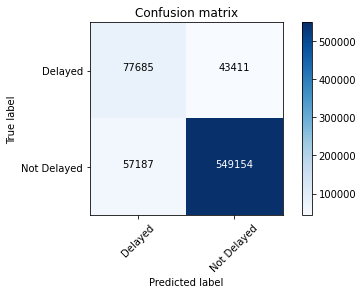

In [0]:
import itertools
from sklearn.metrics import confusion_matrix

class_names=['Delayed','Not Delayed']

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


y_true = testSet.select("label")
y_true = y_true.toPandas()
y_true['label'] = y_true['label'].replace([0],'Not Delayed')
y_true['label'] = y_true['label'].replace([1],'Delayed')

y_pred = testSet.select("prediction")
y_pred = y_pred.toPandas()
y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix')
plt.show()

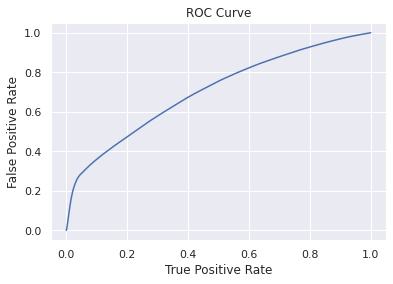

Training set areaUnderROC: 0.7025588419917954


In [0]:
trainingSummary = lr_Model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Interpretation

In [0]:
import shap



## Log Model with Grid Search

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
params = ParamGridBuilder()
params = params.addGrid(lr.regParam, [.01, .1, 1, 10]) \
               .addGrid(lr.elasticNetParam, [0, .5, 1])
params = params.build()

In [0]:
features_to_keep

Out[50]: ['N1h_sum',
 'Q1h_sum',
 'R1h',
 'N2h_sum',
 'Q2h_sum',
 'R2h',
 'N3h_sum',
 'Q3h_sum',
 'R3h',
 'N4h_sum',
 'Q4h_sum',
 'R4h',
 'N5h_sum',
 'Q5h_sum',
 'R5h',
 'N6h_sum',
 'Q6h_sum',
 'R6h',
 'N7h_sum',
 'Q7h_sum',
 'R7h',
 'N8h_sum',
 'Q8h_sum',
 'R8h',
 'N9h_sum',
 'Q9h_sum',
 'R9h',
 'N10h_sum',
 'Q10h_sum',
 'R10h',
 'N11h_sum',
 'Q11h_sum',
 'R11h',
 'N12h_sum',
 'Q12h_sum',
 'R12h']

# Decision Tree

In [0]:
from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

# Load the train set
#train_set = spark.read.parquet(f"{blob_url}/train_set_1")

# Make sure the target variable is not null
train_set = train_set.where("DEP_DEL15 is not NULL")

#train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Use Vetor Assembler to create the features column

#features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
vectorAssembler = VectorAssembler(inputCols =  features_to_keep, outputCol = 'features')
train_df = vectorAssembler.transform(train_set)
train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Load the dev set
#test_set = spark.read.parquet(f"{blob_url}/dev_set_1")
test_set = test_set.where("DEP_DEL15 is not NULL")

#test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Create the features column
test_df = vectorAssembler.transform(test_set)
test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

## Train DT Model

In [0]:
dt = DecisionTreeClassifier(labelCol='label', featuresCol='features', impurity='gini', maxDepth=10, maxBins=32) # 30 trees, 30 max depth is way too much

dt_Model = dt.fit(train_df)

## Evaluate DT Model

In [0]:
testSet = dt_Model.transform(test_df)

In [0]:
dt_predictions = testSet.select("label", "prediction").rdd.map(lambda x: (x[1], x[0]))

evaluator = BinaryClassificationEvaluator()

# calculate AUC
# auc = evaluator.evaluate(rm_predictions, {evaluator.metricName: 'areaUnderROC'})
# print('AUC: %0.3f' % auc)

metrics = MulticlassMetrics(dt_predictions)
precision = metrics.precision(label=1)
print(f'Precision: {precision:.3f}')
recall = metrics.recall(label=1)
print(f'Recall: {recall:.3f}')
f2Score = metrics.fMeasure(1.0, 2.0)
print(f'F2Score: {f2Score:.3f}')

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Precision: 0.576
Recall: 0.642
F2Score: 0.627


Normalized confusion matrix
[[0.64151582 0.35848418]
 [0.09431492 0.90568508]]


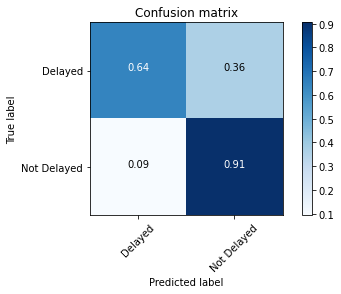

In [0]:
y_true = testSet.select("label")
y_true = y_true.toPandas()
y_true['label'] = y_true['label'].replace([0],'Not Delayed')
y_true['label'] = y_true['label'].replace([1],'Delayed')

y_pred = testSet.select("prediction")
y_pred = y_pred.toPandas()
y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Confusion matrix')
plt.show()

In [0]:
# trainingSummary = dt_Model.summary
# roc = trainingSummary.roc.toPandas()
# plt.plot(roc['FPR'],roc['TPR'])
# plt.ylabel('False Positive Rate')
# plt.xlabel('True Positive Rate')
# plt.title('ROC Curve')
# plt.show()
# print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2647101326227451> in <cell line: 1>()
----> 1 trainingSummary = dt_Model.summary
      2 roc = trainingSummary.roc.toPandas()
      3 plt.plot(roc['FPR'],roc['TPR'])
      4 plt.ylabel('False Positive Rate')
      5 plt.xlabel('True Positive Rate')

AttributeError: 'DecisionTreeClassificationModel' object has no attribute 'summary'

# Random Forest

## Train RF Model

In [0]:
from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

# Load the train set
#train_set = spark.read.parquet(f"{blob_url}/train_set_1")

# Make sure the target variable is not null
train_set = train_set.where("DEP_DEL15 is not NULL")

#train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Use Vetor Assembler to create the features column

#features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
vectorAssembler = VectorAssembler(inputCols =  features_to_keep, outputCol = 'features')
train_df = vectorAssembler.transform(train_set)
train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Load the dev set
#test_set = spark.read.parquet(f"{blob_url}/dev_set_1")
test_set = test_set.where("DEP_DEL15 is not NULL")

#test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Create the features column
test_df = vectorAssembler.transform(test_set)
test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

In [0]:
# NOT BEING RUN AT THE MOMENT
# source: https://shihaojran.com/distributed-machine-learning-using-pyspark/

from pyspark.ml.feature import StringIndexer, OneHotEncoderEstimator

carrier_indexer = StringIndexer(inputCol='OP_UNIQUE_CARRIER', outputCol='arr_idx').setHandleInvalid("keep")
origin_indexer = StringIndexer(inputCol='ORIGIN', outputCol='org_idx').setHandleInvalid("keep")
dest_indexer = StringIndexer(inputCol='DEST', outputCol='des_idx').setHandleInvalid("keep")

# stay away from OneHotEncoderEstimator

onehot = OneHotEncoderEstimator(inputCols=[carrier_indexer.getOutputCol(), origin_indexer.getOutputCol(),
                                           dest_indexer.getOutputCol()],
                                outputCols=['carrier_dummy', 'origin_dummy', 'dest_dummy'])

In [0]:
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml import Pipeline
rf = RandomForestClassifier(labelCol='label', featuresCol='features', 
                            numTrees=30, maxDepth=10) # 30 trees, 30 max depth is way too much

rf_Model = rf.fit(train_df)

#pipeline = Pipeline(stages=[
#     arr_indexer, org_indexer, des_indexer, onehot, 
#    assembler, rf])

In [0]:
testSet = rf_Model.transform(test_df)

In [0]:
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

param = ParamGridBuilder().build()

# cv = CrossValidator(estimator=pipeline,
#                     estimatorParamMaps=params,
#                     evaluator=evaluator,
#                     numFolds=5)

cv = cv.fit(train_set)

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2647101326227153> in <cell line: 3>()
      2 param = ParamGridBuilder().build()
      3 cv = CrossValidator(estimator=pipeline,
----> 4                     estimatorParamMaps=params,
      5                     evaluator=evaluator,
      6                     numFolds=5)

NameError: name 'params' is not defined

## Evaluate RF Model

In [0]:
rm_predictions = testSet.select("label", "prediction").rdd.map(lambda x: (x[1], x[0]))

evaluator = BinaryClassificationEvaluator()

# calculate AUC
# auc = evaluator.evaluate(rm_predictions, {evaluator.metricName: 'areaUnderROC'})
# print('AUC: %0.3f' % auc)

metrics = MulticlassMetrics(rm_predictions)
precision = metrics.precision(label=1)
print(f'Precision: {precision:.3f}')
recall = metrics.recall(label=1)
print(f'Recall: {recall:.3f}')
f2Score = metrics.fMeasure(1.0, 2.0)
print(f'F2Score: {f2Score:.3f}')

/databricks/spark/python/pyspark/sql/context.py:165: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
Precision: 0.561
Recall: 0.671
F2Score: 0.646


In [0]:
rm_predictions.show()

---------------------------------------------------------------------------
AttributeError                            Traceback (most recent call last)
<command-2647101326227399> in <cell line: 1>()
----> 1 rm_predictions.show()

AttributeError: 'PipelinedRDD' object has no attribute 'show'

In [0]:
cm = testSet.groupBy('label','prediction').count().sort('label','prediction')
print("Confusion matrix")
cm.show()

Confusion matrix
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  0.0|       0.0|78445|
|  0.0|       1.0|13370|
|  1.0|       0.0| 8650|
|  1.0|       1.0|24471|
+-----+----------+-----+



In [0]:
y_true = testSet.select("label")
y_true = y_true.toPandas()
y_true['label'] = y_true['label'].replace([0],'Not Delayed')
y_true['label'] = y_true['label'].replace([1],'Delayed')

y_pred = testSet.select("prediction")
y_pred = y_pred.toPandas()
y_pred['prediction'] = y_pred['prediction'].replace([0],'Not Delayed')
y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')

cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)

plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize = True,
                      title='Confusion matrix')
plt.show()

---------------------------------------------------------------------------
NameError                                 Traceback (most recent call last)
<command-2647101326227778> in <cell line: 11>()
      9 y_pred['prediction'] = y_pred['prediction'].replace([1],'Delayed')
     10 
---> 11 cnf_matrix = confusion_matrix(y_true, y_pred,labels=class_names)
     12 
     13 plt.figure()

NameError: name 'confusion_matrix' is not defined

In [0]:
# from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
# params = ParamGridBuilder()
# params = params.addGrid(lr.regParam, [.01, .1, 1, 10]) 
#                .addGrid(lr.elasticNetParam, [0, .5, 1])
# params = params.build()
# cv = CrossValidator(estimator=pipeline,
#                     estimatorParamMaps=params,
#                     evaluator=evaluator,
#                     numFolds=5)

In [0]:
# cv = cv.fit(flights_train)

## Plot ROC Curve

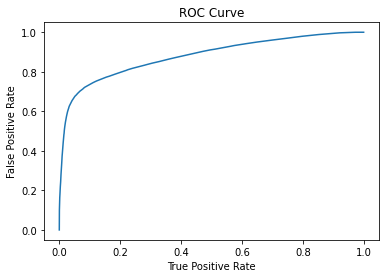

Training set areaUnderROC: 0.8792418225522006


In [0]:
trainingSummary = rf_Model.summary
roc = trainingSummary.roc.toPandas()
plt.plot(roc['FPR'],roc['TPR'])
plt.ylabel('False Positive Rate')
plt.xlabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()
print('Training set areaUnderROC: ' + str(trainingSummary.areaUnderROC))

## Interpreation

In [0]:
import shap

shap_values = shap.TreeExplainer(rf_Model).shap_values(train_set)
shap.summary_plot(shap_values, train_set)

"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is" with a literal. Did you mean "=="?
"is not" with a literal. Did you mean "!="?
"is not" with a literal. Did you mean "!="?


---------------------------------------------------------------------------
Py4JError                                 Traceback (most recent call last)
<command-2647101326227347> in <cell line: 3>()
      1 import shap
      2 
----> 3 shap_values = shap.TreeExplainer(rf_Model).shap_values(train_set)
      4 shap.summary_plot(shap_values, train_set)

/databricks/python/lib/python3.9/site-packages/shap/explainers/_tree.py in __init__(self, model, data, model_output, feature_perturbation, feature_names, approximate, **deprecated_options)
    147         self.feature_perturbation = feature_perturbation
    148         self.expected_value = None
--> 149         self.model = TreeEnsemble(model, self.data, self.data_missing, model_output)
    150         self.model_output = model_output
    151         #self.model_output = self.model.model_output # this allows the TreeEnsemble to translate model outputs types by how it loads the model

/databricks/python/lib/python3.9/site-packages/shap/expl

In [0]:
# from pyspark.sql.functions import udf
# from pyspark.sql.types import FloatType

# secondelement=udf(lambda v:float(v[1]),FloatType())
# pred2=pred.withColumn('probs',secondelement('probability'))

# import matplotlib.pyplot as plt
# from sklearn.metrics import roc_curve
# import seaborn as sns

# pd5 = pred2.sample(False,0.1).select('label','probs').toPandas()

# fpr, tpr, _ = roc_curve( pd5['label'], pd5['probs'])

# plt.plot(fpr, tpr)
# plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
# plt.xlabel('1 - Esp (FPR)')
# plt.ylabel('Sens (TPR)')
# plt.title('Curva ROC')
# plt.show()

In [0]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator as BCE

print('AUC=',BCE(metricName="areaUnderROC",rawPredictionCol = 'probability').evaluate(pred))

In [0]:
# # source : https://stackoverflow.com/questions/52847408/pyspark-extract-roc-curve
# from pyspark.mllib.evaluation import BinaryClassificationMetrics

# class CurveMetrics(BinaryClassificationMetrics):
#     def __init__(self, *args):
#         super(CurveMetrics, self).__init__(*args)

#     def _to_list(self, rdd):
#         points = []
#         # Note this collect could be inefficient for large datasets 
#         # considering there may be one probability per datapoint (at most)
#         # The Scala version takes a numBins parameter, 
#         # but it doesn't seem possible to pass this from Python to Java
#         for row in rdd.collect():
#             # Results are returned as type scala.Tuple2, 
#             # which doesn't appear to have a py4j mapping
#             points += [(float(row._1()), float(row._2()))]
#         return points

#     def get_curve(self, method):
#         rdd = getattr(self._java_model, method)().toJavaRDD()
#         return self._to_list(rdd)
    


In [0]:
# import matplotlib.pyplot as plt

# # Create a Pipeline estimator and fit on train DF, predict on test DF
# # model = estimator.fit(train)
# # predictions = model.transform(test)

# # Returns as a list (false positive rate, true positive rate)
# preds = testSet.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
# points = CurveMetrics(preds).get_curve('roc')

# plt.figure()
# x_val = [x[0] for x in points]
# y_val = [x[1] for x in points]
# plt.title(title)
# plt.xlabel(xlabel)
# plt.ylabel(ylabel)
# plt.plot(x_val, y_val)

---------------------------------------------------------------------------
Py4JError                                 Traceback (most recent call last)
<command-2647101326227133> in <cell line: 9>()
      7 # Returns as a list (false positive rate, true positive rate)
      8 preds = testSet.select('label','probability').rdd.map(lambda row: (float(row['probability'][1]), float(row['label'])))
----> 9 points = CurveMetrics(preds).get_curve('roc')
     10 
     11 plt.figure()

<command-2647101326227126> in get_curve(self, method)
     19 
     20     def get_curve(self, method):
---> 21         rdd = getattr(self._java_model, method)().toJavaRDD()
     22         return self._to_list(rdd)
     23 

/databricks/spark/python/lib/py4j-0.10.9.5-src.zip/py4j/java_gateway.py in __call__(self, *args)
   1319 
   1320         answer = self.gateway_client.send_command(command)
-> 1321         return_value = get_return_value(
   1322             answer, self.gateway_client, self.target_id, self.n

In [0]:
display(train_set)

# XG BOOST

In [0]:

from pyspark.sql.functions import lit
from pyspark.mllib.evaluation import MulticlassMetrics
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler
from pyspark.sql.functions import col

from sparkdl.xgboost import XgboostRegressor
from sparkdl.xgboost import XgboostClassifier

# Load the train set
#train_set = spark.read.parquet(f"{blob_url}/train_set_1")

# Make sure the target variable is not null
train_set = train_set.where("DEP_DEL15 is not NULL")

#train_set = train_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Use Vetor Assembler to create the features column

#features_to_keep = ['DISTANCE', 'PREV_DEP_DELAY', 'CRS_DEP_TIME', 'CRS_ARR_TIME']
vectorAssembler = VectorAssembler(inputCols =  features_to_keep, outputCol = 'features')
train_df = vectorAssembler.transform(train_set)
train_df = train_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")

# Load the dev set
#test_set = spark.read.parquet(f"{blob_url}/dev_set_1")
test_set = test_set.where("DEP_DEL15 is not NULL")

#test_set = test_set.withColumn("PREV_DEP_DELAY", col("PREV_DEP_DELAY").cast('int'))

# Create the features column
test_df = vectorAssembler.transform(test_set)
test_df = test_df.select(['features', 'DEP_DEL15']).withColumnRenamed("DEP_DEL15", "label")



In [0]:
paramGrid_xgboost = {'max_depth':3,
                     'n_estimators':150,
                     'reg_lambda':1,
                     'reg_alpha':0,
                     'objective':'binary:logistic',
                     'base_score':0.5,
                     'learning_rate':0.2,
                     'gamma':0.05,
                     'scale_pos_weight':2,
                     'min_child_weight':1.5}


xgclassi = XgboostClassifier(paramGrid_xgboost).setFeaturesCol("features").setLabelCol('label')


---------------------------------------------------------------------------
TypeError                                 Traceback (most recent call last)
<command-2647101326233371> in <cell line: 13>()
     11 
     12 
---> 13 xgclassi = XgboostClassifier(paramGrid_xgboost).setFeaturesCol("features").setLabelCol('label')

TypeError: __init__() takes 1 positional argument but 2 were given

In [0]:

XG_Model = xgboost.fit(train_df)